In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn

In [ ]:
normalize_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5,0.5,0.5), std=((0.5,0.5,0.5)))])

In [ ]:
train_dataset = datasets.CIFAR10(
    root = "./CIFAR10/train",
    train = True,
    transform = normalize_transform,
    download = True
)
test_dataset = datasets.CIFAR10(
    root = "./CIFAR10/test",
    train = False,
    transform = normalize_transform,
    download = True
)

In [ ]:
Batch_size = 256
train_loader = DataLoader(train_dataset, batch_size = Batch_size)
test_loader = DataLoader(test_dataset, batch_size = Batch_size)

In [ ]:
dataiter = iter(train_loader)
image, label = dataiter.next()

(-0.5, 165.5, 165.5, -0.5)

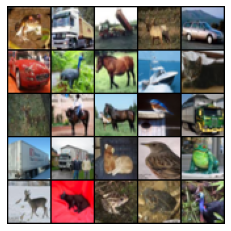

In [ ]:
plt.imshow(np.transpose(torchvision.utils.make_grid(image[:25], normalize=True, padding = 1, nrow = 5).numpy(), (1,2,0)))
plt.axis('off')

In [ ]:
classes = []
for i, data in enumerate(train_loader):
  x,y = data
  classes.extend(y.tolist())

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
    nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2), 
    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(64*2*2, 512),
    nn.ReLU(),
    nn.Linear(512, 10))

  def forward(self,x):
    return self.model(x)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Classifier().to(device)

In [ ]:
model

In [ ]:
epochs = 15
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
train_loss_list = []
for epoch in range(epochs):
    print(f'Epoch {epoch + 1}')
    train_loss = 0

    model.train()
    for i, (images,labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output,labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss_list.append(train_loss/len(train_loader))
    print(f'Training Loss = {train_loss_list[-1]}')

In [ ]:
plt.plot(range(1,epochs + 1), train_loss_list)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")

In [ ]:
test_acc = 0
model.eval()
with torch.no_grad():

  for i, (image, label) in enumerate(test_loader):
    image, label = image.to(device), label.to(device)
    outputs = model(image)

    _ , y_pred = torch.max(outputs, 1)

    test_acc += (y_pred == label).sum().item()

  print(f'Test Accuracy is = {100 * test_acc / len(test_dataset)} %')